In [1]:
# Wrangling libraries
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Load models
import pickle

In [6]:
# Read hdb data from csv
full_hdb_df = pd.read_parquet('../data/processed/final_HDB_for_model.parquet.gzip')

# Future economic data
econ_df = pd.read_csv('../data/processed/sg_econ_data_historical_future.csv')

In [3]:
denseNN = pickle.load(open('../models/denseNN_231214.pkl', 'rb'))

In [4]:
# Extract a single random row from full HDB data
sample_df = full_hdb_df.sample()

# Drop unnecessary columns for the model
# Put all columns to be deleted into a list
drop_cols = ['block', 'street_name','address','sold_year_month', 'resale_price'] + \
            ['sold_year', 'sold_remaining_lease',
             '5 year bond yields','GDPm (Current Prices)', 'GDP per capita', 'Personal Income m',
             'Unemployment Rate', 'Core inflation', 'Median Household Inc',
             'Lime, Cement, & Fabricated Construction Materials Excl Glass & Clay Materials',
             'Clay Construction Materials & Refractory Construction Materials',
             'ResidentPopulation','ResidentPopulation_Growth_Rate']

# Drop columns
sample_df = sample_df.drop(columns=drop_cols)

# Vew Sample Row
sample_df

,town,flat_type,storey_range,floor_area_sqm,flat_model,lease_commence_date,max_floor_lvl,most_closest_mrt,walking_time_mrt
744303,PUNGGOL,4 ROOM,10 TO 12,95.0,Premium Apartment,2003,17.0,PUNGGOL,1837.0


In [9]:
# Take first row of sample and create to create testing dataframe
# Code written like this so that it can also be used with the preselected sample dataframe
pred_df = sample_df.iloc[0:1].copy().reset_index(drop=True)

# Create variables to use in the creating of the testing data frame
resale_year = pred_df['lease_commence_date'][0] + 4
factor = 2034 - pred_df['lease_commence_date'][0] - 4

# Multiply single sample row to insert testing data for each year
pred_df = pd.concat([pred_df] * factor, ignore_index=True)

# Create year column using variables created earlier
year_range = range(resale_year, resale_year + factor)
pred_df['sold_year'] = year_range

# Include economic data in the testing dataframe
pred_df = pred_df.merge(econ_df, left_on='sold_year', right_on='year', how='left')

# Create remaining lease column for prediction years
pred_df['sold_remaining_lease'] = 99 - (pred_df['sold_year'] - pred_df['lease_commence_date'])

# Reorient columns to be used in the pipelines
pred_df = pred_df[['town', 'flat_type', 'storey_range', 'floor_area_sqm', 'flat_model',
       'lease_commence_date', 'sold_year', 'sold_remaining_lease',
       'max_floor_lvl', '5 year bond yields', 'GDPm (Current Prices)',
       'GDP per capita', 'Personal Income m', 'Unemployment Rate',
       'Core inflation', 'Median Household Inc',
       'Lime, Cement, & Fabricated Construction Materials Excl Glass & Clay Materials',
       'Clay Construction Materials & Refractory Construction Materials',
       'most_closest_mrt', 'walking_time_mrt', 'ResidentPopulation',
       'ResidentPopulation_Growth_Rate']]

# Remove any dates before 1990 as it creates NaNs
pred_df = pred_df[pred_df['sold_year'] >= 1990].reset_index(drop=True)

# Apply model and put predictions in new column
pred_df['dnn'] = denseNN.predict(pred_df)

# Extract results into new dataframe for plotting
prediction_results = pred_df[['sold_year', 'dnn']]

# Extract historical data from full HDB dataframe for plotting against test results
temp = full_hdb_df[(full_hdb_df['town'] == pred_df['town'][0]) &
                                    (full_hdb_df['flat_type'] == pred_df['flat_type'][0]) &
                                    (full_hdb_df['storey_range'] == pred_df['storey_range'][0]) &
                                    (full_hdb_df['most_closest_mrt'] == pred_df['most_closest_mrt'][0])
                                    ].groupby(['sold_year'])['resale_price'].mean()\
                                     .to_frame(name='historical_mean').reset_index()

# Include historical mean resale prices in test results dataframe
prediction_results = prediction_results.merge(temp, on = 'sold_year', how = 'left')

# View
prediction_results

1/1 [==============================] - 0s 13ms/step


,sold_year,dnn,historical_mean
0,2007,257057.84375,265256.818182
1,2008,306894.56250,316429.032258
2,2009,331609.40625,337543.375000
3,2010,371557.84375,386629.032258
4,2011,432469.65625,443993.411765
5,2012,467497.90625,492273.629630
6,2013,476463.53125,512013.428571
7,2014,420384.78125,466464.000000
8,2015,393025.34375,436974.571429
9,2016,379209.15625,457195.823009


In [12]:
prediction_results['model_growth_rate'] = prediction_results['dnn'].pct_change(periods=1, fill_method = None) * 100
prediction_results['actual_growth_rate'] = prediction_results['historical_mean'].pct_change(periods=1, fill_method = None) * 100
prediction_results

,sold_year,dnn,historical_mean,model_growth_rate,actual_growth_rate
0,2007,257057.84375,265256.818182,NaN,NaN
1,2008,306894.56250,316429.032258,19.387352,19.291574
2,2009,331609.40625,337543.375000,8.053207,6.672695
3,2010,371557.84375,386629.032258,12.046838,14.542030
4,2011,432469.65625,443993.411765,16.393625,14.837059
5,2012,467497.90625,492273.629630,8.099580,10.874084
6,2013,476463.53125,512013.428571,1.917791,4.009924
7,2014,420384.78125,466464.000000,-11.769790,-8.896139
8,2015,393025.34375,436974.571429,-6.508189,-6.321909
9,2016,379209.15625,457195.823009,-3.515345,4.627558


In [13]:
prediction_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sold_year           27 non-null     int64  
 1   dnn                 27 non-null     float32
 2   historical_mean     17 non-null     float64
 3   model_growth_rate   26 non-null     float32
 4   actual_growth_rate  16 non-null     float64
dtypes: float32(2), float64(2), int64(1)
memory usage: 992.0 bytes


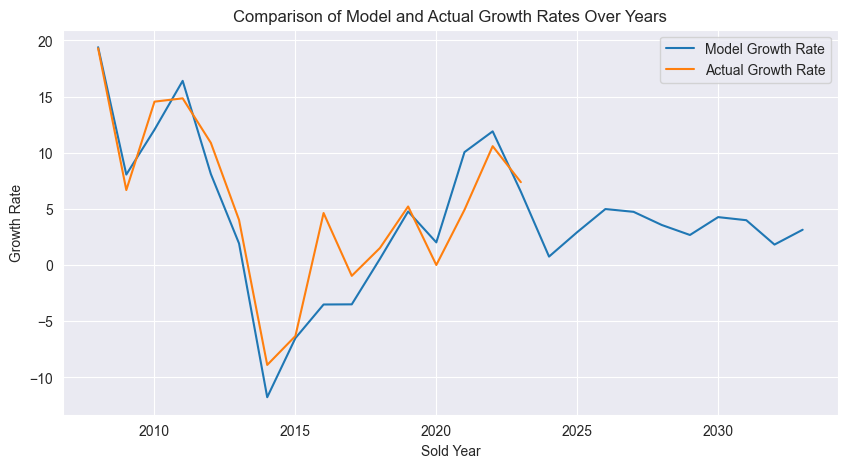

In [50]:
# Plotting
plt.figure(figsize=(10, 5))
sns.set_style("darkgrid")
sns.lineplot(data=prediction_results, x='sold_year', y='model_growth_rate', label='Model Growth Rate')
sns.lineplot(data=prediction_results, x='sold_year', y='actual_growth_rate', label='Actual Growth Rate')

plt.title('Comparison of Model and Actual Growth Rates Over Years')
plt.xlabel('Sold Year')
plt.ylabel('Growth Rate')
plt.legend()
plt.show()

In [53]:
# Create a long-form DataFrame suitable for Plotly Express
long_df = prediction_results.melt(id_vars='sold_year', value_vars=['model_growth_rate', 'actual_growth_rate'],
                                  var_name='Type', value_name='Growth Rate')

# Plotting with regression lines
fig = px.scatter(long_df, x='sold_year', y='Growth Rate', color='Type', trendline="expanding")

# Updating plot layout
fig.update_layout(title='Model vs Actual Growth Rates with Expanding Mean Moving Average',
                  xaxis_title='Sold Year',
                  yaxis_title='Growth Rate',
                  legend_title='Type',
                  width = 1000,
                  height = 500)
fig.show()

In [ ]:
# Calculating mean forecast_CAGR by town and flat_type
mean_forecast_CAGR = hdb_df.groupby(['town', 'flat_type'])['forecast_CAGR'].mean().reset_index().sort_values('forecast_CAGR', ascending=False)

# Creating a stacked bar plot using Plotly
fig = px.bar(mean_forecast_CAGR, x='town', y='forecast_CAGR', color='flat_type',
             labels={'forecast_CAGR': 'Mean Forecast CAGR'},
             title='Mean Forecast CAGR by Town and Flat Type (Stacked)',
             barmode='stack')
fig.update_layout(legend_title = 'Click Type Below to Add/Remove')
fig.update_traces(visible="legendonly")
fig.data[3].visible = True

# Show the plot
fig.show()

In [ ]:
# Plotting the results using Plotly
fig = px.density_heatmap(mean_forecast_CAGR, x='town', y='flat_type', z='forecast_CAGR',
                         title='Heatmap of Ten Year Mean Forecast CAGR from 2024 - 2033 by Town and Flat Type',
                         category_orders={"flat_type": sorted(mean_forecast_CAGR['flat_type'].unique())})

# Changing the legend title and tracer
fig.update_layout(coloraxis_colorbar=dict(title='Mean CAGR'))
fig.update_traces(hovertemplate='Town: %{x}<br>Flat Type: %{y}<br>Mean CAGR: %{z}')

# Show the figure
fig.show()

In [ ]:
# Calculate the average forecast_appreciation_amount by town
avg_app_by_town_room = hdb_df.groupby(['town', 'flat_type'])['forecast_appreciation_amount'].mean().reset_index().sort_values(['forecast_appreciation_amount','flat_type'], ascending=False)

# Plotting the results using Plotly
fig = px.bar(avg_app_by_town_room, x='town', y='forecast_appreciation_amount', color='flat_type',
             labels={'forecast_appreciation_amount': 'Mean Forecast Appreciation ($SGD)'},
             title='Ten Year Mean Forecast HDB Resale Price Appreciation from 2024 - 2033 by Town and Flat Type')
fig.update_layout(legend_title = 'Click Type Below to Add/Remove')
fig.update_traces(visible="legendonly")
fig.data[3].visible = True

# Show the figure
fig.show()

In [ ]:
fig = px.density_heatmap(avg_app_by_town_room, x='town', y='flat_type', z='forecast_appreciation_amount',
                         title='Heatmap of Ten Year Mean Forecast HDB Resale Price Appreciation from 2024 - 2033 by Town and Flat Type',
                         category_orders={"flat_type": sorted(avg_app_by_town_room['flat_type'].unique())})

# Changing the legend title and tracer
fig.update_layout(coloraxis_colorbar=dict(title='Mean Appreciation'))
fig.update_traces(hovertemplate='Town: %{x}<br>Flat Type: %{y}<br>Mean Appreciation: %{z}')

fig.show()